## Testing of field curvature
### Imaging setup:
- Lens: [Lensagon 1.2x](https://www.lensation.de/product/T25M-12-155I/)
- Camera: Photometrix Iris 15
- Test sample: Ronchi grating (e.g. 40 lp/mm from Thorlabs) imaged at different focus position (stack).
- Illumination: even background using a smartphone screen (all white)

MTF is accessed across field of view via local contrast metric.

Inspired by Roger Cicala's [blog post](https://www.lensrentals.com/blog/2018/06/developing-a-rapid-mtf-test-for-photo-and-video-lenses/).

This code is exploratory, not meant for streamlined processing.

- Author: Nikita Vladimirov 
- License: GPL-3.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tif
import glob, os
from pathlib import Path

### Explore TIFF stack of a Ronchi grid at different F-position

In [4]:
datafolder = "D:\\benchtopData\\Lens-testing"
datafiles = {"Lensagon 1.2x": datafolder + "\\Lensagon1.2x\\ronchi40-fstep10\\Tile0_Ch488_Sh0.tiff"}
f_step_um = 10

In [5]:
img = tif.imread(datafiles["Lensagon 1.2x"])
im_z, im_h, im_w = img.shape
print(im_z, im_h, im_w)
print(f"Aspect ratio {im_w/im_h}")

61 5056 2960
Aspect ratio 0.5854430379746836


In [6]:
# The number of ROIs to divide image along each axis
N_ROIs_H, N_ROIs_W = 32, 20
#N_ROIs_H, N_ROIs_W = 16, 10 #these give integer number of rois along each axis, with aspect ratio close to the sensor ratio
roi_h, roi_w = int(im_h/N_ROIs_H), int(im_w/N_ROIs_W)
print(roi_h, roi_w)

158 148


6096 30263


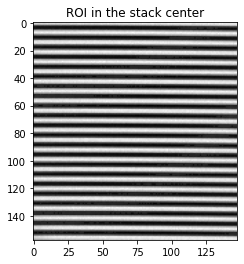

In [7]:
roi = img[im_z//2, roi_h*(N_ROIs_H//2 - 1): roi_h*(N_ROIs_H//2), 
               roi_w*(N_ROIs_W//2 - 1) : roi_w*(N_ROIs_W//2)]
plt.imshow(roi, cmap='gray')
plt.title("ROI in the stack center")
print(roi.min(), roi.max())

In [8]:
def contrast(roi):
    """Compute the contrast value, (max-min)/(max+min), from the image roi"""
    mini = np.percentile(roi, 1)
    maxi = np.percentile(roi, 99)
    contrast = (maxi - mini) / (maxi + mini)
    return contrast

In [9]:
(N_ROIs_H//2 - 1), (N_ROIs_W//2 - 1)

(15, 9)

In [10]:
roi0 = img[im_z//2, roi_h*(N_ROIs_H//2 - 1): roi_h*(N_ROIs_H//2), roi_w*(N_ROIs_W//2 - 1) : roi_w*(N_ROIs_W//2)]
roi1 = img[im_z//2, roi_h*(N_ROIs_H//2): roi_h*(N_ROIs_H//2 + 1), roi_w*(N_ROIs_W//2) : roi_w*(N_ROIs_W//2 + 1)]

c0 = contrast(roi0)
c1 = contrast(roi1)
print(c0,c1)

0.6317823785371801 0.6201312777517305


In [77]:
print(roi0.min(), roi0.max(), roi0.max() - roi0.min())
print(roi1.min(), roi1.max(), roi1.max() - roi1.min())

6096 30263 24167
6249 30410 24161


In [74]:
print(np.percentile(roi0, 1), np.percentile(roi0, 99))
print(np.percentile(roi1, 1), np.percentile(roi1, 99))

6642.83 29438.17
6886.83 29372.17


In [11]:
contrast_table = np.empty((im_z, N_ROIs_H, N_ROIs_W))
for f in range(im_z):
    for j in range(N_ROIs_H):
        for i in range(N_ROIs_W):
            roi = img[f,j*roi_h:(j+1)*roi_h, i*roi_w:(i+1)*roi_w]
            contrast_table[f,j,i] = contrast(roi)

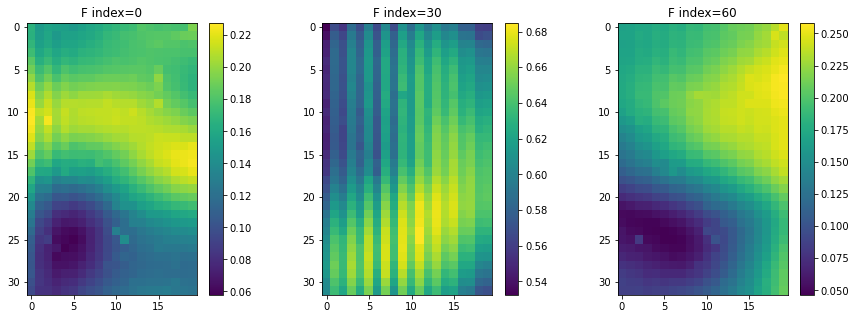

In [12]:
fig = plt.figure(figsize=(15, 5))
for ind, f in enumerate([0, im_z//2, im_z-1]):
    ax = plt.subplot(1, 3, ind+1)
    conmap = ax.imshow(contrast_table[f,:,:])
    ax.set_title("F index=" + str(f))
    plt.colorbar(conmap,ax=ax)

In [38]:
# Save contrast table as TIFF and explore interactively
tif.imsave(datafiles["Lensagon 1.2x"][:-4] + "contrast.tiff", contrast_table)

Note the vertical stripes, most likely due to flikering of smartphone screen at about 60Hz. Increase the cam exposure time to 50-100 ms to time-average the flickering.

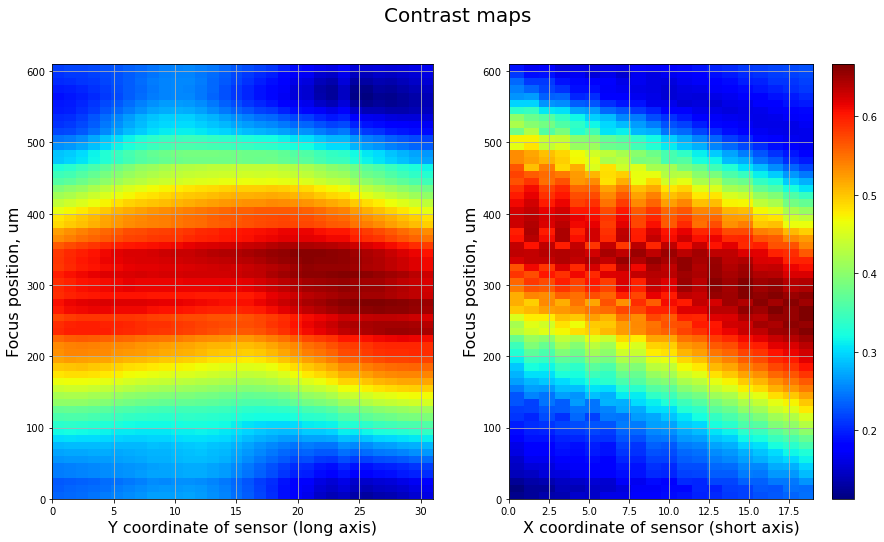

In [16]:
# slice the contrast map along XZ and YZ axis, therough the center
j = N_ROIs_W//2
contrast_yz = np.squeeze(contrast_table[:,:,j])
contrast_xz = np.squeeze(contrast_table[:,N_ROIs_H//2,:])

fig = plt.figure(figsize=(15, 8))
fig.suptitle('Contrast maps', fontsize=20)
ax0 = plt.subplot(1, 2, 1)
conmap0 = ax0.imshow(contrast_yz, extent=[0,N_ROIs_H-1, 0, f_step_um*im_z], aspect='auto', cmap='jet')
ax0.set_ylabel("Focus position, um", fontsize=16)
ax0.set_xlabel("Y coordinate of sensor (long axis)", fontsize=16)
ax0.grid(True)

ax1 = plt.subplot(1, 2, 2)
conmap1 = ax1.imshow(contrast_xz, extent=[0,N_ROIs_W-1, 0, f_step_um*im_z], aspect='auto', cmap='jet')
ax1.set_ylabel("Focus position, um", fontsize=16)
ax1.set_xlabel("X coordinate of sensor (short axis)", fontsize=16)
ax1.grid(True)
plt.colorbar(conmap1,ax=ax1)

Note that right plot has larger change of contrast along focus axis, due to significant ronchi grating tilt along X axis. The sensor size along X is is alo too short to visualize the section of a circle, as on the left plot. So, left plot can be used for filed curvature estimation, not the right plot.

### Field curvature estimate
From visual estimation of the left plot, total sag of field curvature sphere appears to be around **70 micron across sensor long axis 21.49 mm, or 40 micron across the short axis (12.61 mm, coaxial with light-sheet beam)**. It is acceptable from optics point (depth of field is [187 um](https://www.lensation.de/product/T25M-12-155I/) for this lens). However, not ideal from lightsheet microscopy point.

In [17]:
# DOF calculation for the lens
# Based on [MicroscopyU](https://www.microscopyu.com/microscopy-basics/depth-of-field-and-depth-of-focus) formula.
# All units micron. Air objective.
n_det = 1 
cam_px_size = 4.25
lamb_em = 0.550
NA = 0.08
MAG = 1.2

DOF = n_det*lamb_em/NA**2 + n_det*cam_px_size/(MAG*NA)
print(f"Estimated DOF={int(DOF)} um, in air")

Estimated DOF=130 um, in air


Up next: compare this to field curvature of Olympus PLAPO 1x with the closest zoom (1.25x).